In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from flarestack import EnergyPDF
from flarestack.cosmo import get_rate, get_diffuse_flux, calculate_transient_cosmology, get_diffuse_flux_contour
from astropy import units as u
import numpy as np
import logging
logging.getLogger().setLevel("INFO")

In [2]:
frb_rate = get_rate("frb")
print(f"Local FRB rate is {frb_rate(0.0):.2g}")

INFO:root:No evolution specified. Assuming default evolution.
INFO:root:Loaded evolution 'madau_14' (http://arxiv.org/abs/1403.0007v3)
INFO:root:No rate specified. Assuming default rate.
INFO:root:Loaded rate 'bochenek_20' (https://arxiv.org/abs/2005.10828)


Local FRB rate is 0.072 1 / (Mpc3 yr)


Distance to SGR 1935+2154 is 4-16 kpc (https://arxiv.org/abs/2005.10828). Take 16, to be conservative!

In [3]:
dist = 16 * u.kpc

IceCube Limit is E2 dNdE = 5.2 × 10−2 GeV cm^-2 @ 1 GeV (http://www.astronomerstelegram.org/?read=13689)

In [22]:
norm_energy = 1.*u.GeV
spectrum_gamma = 2.0

# dN/dE
atel_flux_norm_lim = 5.2 * 10**-2. * (u. GeV / u.cm**2) / (norm_energy)**2.

e_pdf_dict = {
    "energy_pdf_name": "power_law",
    "gamma": spectrum_gamma,
    "e_min_gev": 10.**3,
    "e_max_gev": 10.**6,
}

epdf = EnergyPDF.create(e_pdf_dict)

INFO:flarestack.core.energy_pdf:Minimum Energy is 1e+03 GeV.
INFO:flarestack.core.energy_pdf:Maximum Energy is 1e+06 GeV.


In [23]:
e_lim = (atel_flux_norm_lim * epdf.fluence_integral() * norm_energy**2 * 4 * np.pi * dist.to("cm")**2.).to("erg")
print(f"Muon Neutrino Energy limit for SGR 1935+2154 is {e_lim:.2g} between {epdf.e_min:.2g} GeV and {epdf.e_max:.2g} GeV")

Muon Neutrino Energy limit for SGR 1935+2154 is 1.8e+43 erg between 1e+03 GeV and 1e+06 GeV


In [24]:
limits = [
    ("Standard Candle", atel_flux_norm_lim),
    (r"$E_{\nu} \propto E_{FRB}$", atel_flux_norm_lim*10.)
]

INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'northern_tracks_19' from https://arxiv.org/abs/1908.09551
INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'northern_tracks_19' from https://arxiv.org/abs/1908.09551
INFO:flarestack.cosmo.neutrino_cosmology:Using the northern_tracks_19 best fit values of the diffuse flux.
INFO:flarestack.cosmo.neutrino_cosmology:Diffuse Flux at 1 GeV: 3.6171164613737875e-07 1 / (cm2 GeV s sr)
INFO:flarestack.cosmo.neutrino_cosmology:Diffuse Spectral Index is 2.28
INFO:flarestack.core.energy_pdf:Minimum Energy is 1e+03 GeV.
INFO:flarestack.core.energy_pdf:Maximum Energy is 1e+06 GeV.
INFO:flarestack.cosmo.neutrino_cosmology:Neutrino Energy is 1.8e+43 erg
INFO:flarestack.cosmo.neutrino_cosmology:Neutrino Flux at 1 GeV is 1.6e+45 1 / GeV
INFO:flarestack.cosmo.neutrino_cosmology:Local rate is 0.072 1 / (Mpc3 yr)
INFO:flarestack.cosmo.neutrino_cosmology:Cumulative sources at z=8.0: 2.9e+11
INFO:flarestack.cosmo.neutrino_cosmology:Cumulative

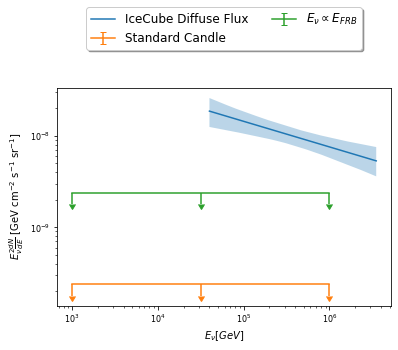

In [26]:
# Use joint diffuse flux fit (https://arxiv.org/abs/1507.03991)

fit = "northern_tracks_19"

plt.figure()
ax = plt.subplot(111)

best_fit, upper_butterfly, lower_butterfly, e_range = get_diffuse_flux_contour(fit=fit)

plt.plot(e_range, best_fit(e_range) * e_range**2, label="IceCube Diffuse Flux")

plt.fill_between(e_range, upper_butterfly(e_range)* e_range**2, lower_butterfly(e_range)* e_range**2, alpha=0.3)

for label, mean_flux_norm_lim in limits:
    
    lim_e_pdf_dict = dict(e_pdf_dict)
    lim_e_pdf_dict["nu_flux_at_1_gev"] = mean_flux_norm_lim * 4 * np.pi * dist**2.

    integrated_nu_flux_1_gev = calculate_transient_cosmology(
        lim_e_pdf_dict, frb_rate, "frb_limit", zmax=8.0, diffuse_fit=fit,
    )
        
    x = [epdf.e_min, np.exp(0.5*(np.log(epdf.e_min) + np.log(epdf.e_max))), epdf.e_max]
    y = np.array([integrated_nu_flux_1_gev.value for _ in range(3)]) 

    plt.errorbar(x, y, yerr=0.25*y, uplims=True, label=label)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$E_{\nu} [GeV] $")
plt.ylabel(r"$E_{\nu}^{2} \frac{dN}{dE}$ [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),
          ncol=2, fancybox=True, shadow=True, fontsize=12)